In [43]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from collections import Counter

In [44]:
# Constants
DATA_PATH = "/users/mik2002/som/dataset-processed/"
FILES = ["processed_bot_dataset.csv", "processed_dos_dataset.csv", "processed_bruteforce_dataset.csv"]

In [45]:
df_dataset = pd.concat([pd.read_csv(DATA_PATH + file) for file in FILES],ignore_index=True)

In [46]:
  # Calcola le proporzioni delle classi nel dataset originale
class_proportions = df_dataset["Label"].value_counts(normalize=True)
print("Proporzioni delle classi nel dataset originale:")
print(class_proportions)
    
    # Esegui il campionamento casuale stratificato mantenendo le proporzioni delle classi
sampled_df = df_dataset.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))

Proporzioni delle classi nel dataset originale:
Label
Benign        0.751210
Dos           0.133427
Bot           0.074191
Bruteforce    0.041172
Name: proportion, dtype: float64


/tmp/ipykernel_247255/4251887621.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_dataset.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))


In [47]:

"""Preprocess the data for modeling."""
df_dataset["Label"] = df_dataset["Label"].map({"Benign": 0, "Dos": 1, "Bot": 2, "Bruteforce": 3})
scaler = MinMaxScaler()
data = scaler.fit_transform(df_dataset.iloc[:,:-1])
target = df_dataset.iloc[:,-1].values

In [48]:
def classify(som, data, training_data, training_labels):
    """
    Classifies each sample in data using the trained SOM and a labels map.
    
    Parameters:
        som (MiniSom): The trained MiniSom instance.
        data (numpy.array): Data to classify.
        training_data (numpy.array): Training data used to build the labels map.
        training_labels (numpy.array): Labels corresponding to the training data.
    
    Returns:
        list: List of predicted labels for the data.
    """
    from collections import Counter
    
    # Create a labels map from the training data
    winmap = som.labels_map(training_data, training_labels)
    
    # Determine the default class as the most frequent class in the training labels
    default_class = Counter(training_labels).most_common(1)[0][0]
    
    result = []
    for sample in data:
        winner = som.winner(sample)
        if winner in winmap:
            result.append(winmap[winner].most_common(1)[0][0])
        else:
            result.append(default_class)
    return result


In [49]:
# Divisione dei dati in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


input_len = X_train.shape[1]
iterations = X_train.shape[0]

som = MiniSom(x=15, y=15, input_len=input_len, sigma=1.5, learning_rate=1.2)
som.random_weights_init(X_train)

# Addestramento del SOM
som.train(X_train, iterations, verbose=True) 

# Valutazione dell'errore topografico
topographic_error = som.topographic_error(X_train)
print(f'Topographic error: {topographic_error}')

# Classificazione dei dati di test e produzione del report
y_pred = classify(som, X_test, X_train, y_train)
report = classification_report(y_test, y_pred, digits=4)
print(report)

Training set has 2283112 samples.
Testing set has 1522076 samples.
 [ 2283112 / 2283112 ] 100% - 0:00:00 left 
 quantization error: 0.021642307236428335
Topographic error: 0.03545861963845839
              precision    recall  f1-score   support

           0     0.9932    0.9955    0.9943   1142796
           1     0.9918    0.9481    0.9695    203496
           2     0.9830    0.9421    0.9621    113078
           3     0.8511    1.0000    0.9195     62706

    accuracy                         0.9854   1522076
   macro avg     0.9548    0.9714    0.9614   1522076
weighted avg     0.9864    0.9854    0.9855   1522076



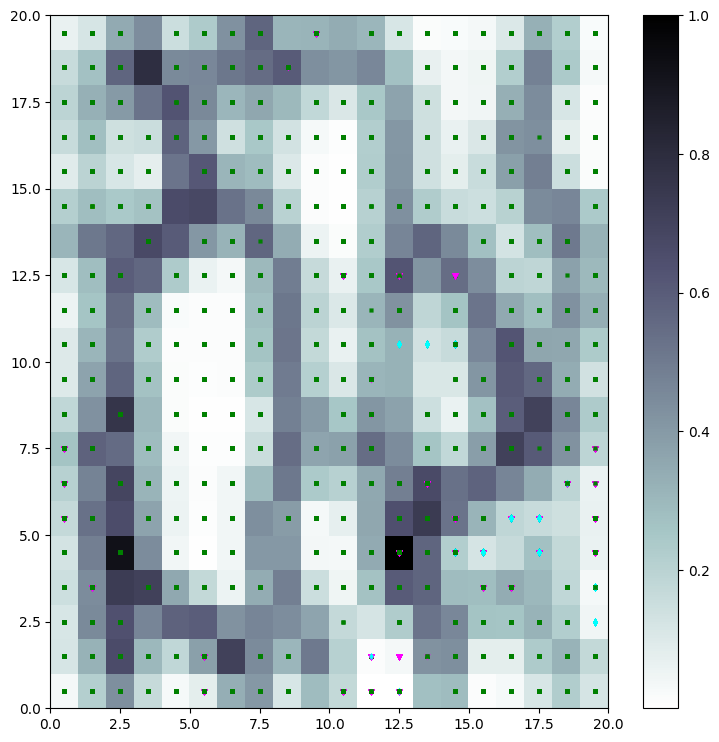

CPU times: user 1h 7min 32s, sys: 2min 30s, total: 1h 10min 3s
Wall time: 1h 9min 57s


In [50]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the processed_friday_dataset
# different colors and markers for each label
markers = ['s', 'v','p','d']
colors = ['green', 'magenta','yellow','cyan']

for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor=colors[target[cnt]],
             markeredgecolor=colors[target[cnt]], markersize=1, markeredgewidth=2)


plt.show()

Percentage distribution (320688/3805188)*100) at the densest point: 8.427651932046459%


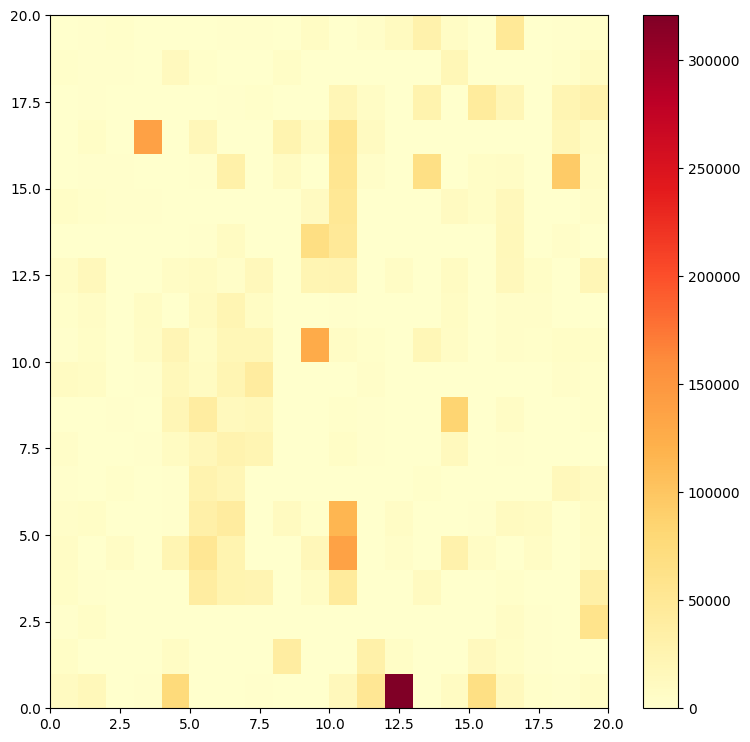

CPU times: user 6min 32s, sys: 113 ms, total: 6min 32s
Wall time: 6min 32s


In [51]:
%%time
# Compute the activation map
frequencies = som.activation_response(data)

# Find the maximum value in the activation map
max_value = np.max(frequencies)

# Calculate the percentage distribution at the densest point
densest_point_percentage = (max_value / len(data)) * 100

# Print the percentage distribution
print(f"Percentage distribution ({int(max_value)}/{len(data)})*100) at the densest point: {densest_point_percentage}%")

# Display the activation map
plt.figure(figsize=(9, 9))
plt.pcolor(frequencies.T,cmap='YlOrRd')
plt.colorbar()
plt.show()

In [52]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from minisom import MiniSom

# Supponiamo di avere X come dati e y come etichette
# Selezioniamo i dati e le etichette correttamente
X = df_dataset.iloc[:, :-1].values  # Dati
y = df_dataset.iloc[:, -1].values  # Etichette

# Dividi il dataset in fold per la cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Esempio con 5 fold

# Definisci i parametri per MiniSom
som_shape = (20, 20)  # Esempio di dimensioni della mappa SOM
learning_rate = 1.2
sigma = 1.5
n_iterations = X_train.shape[0]


# Lista per memorizzare i report di ciascuna fold
report_list = []

# Loop per la cross-validation
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inizializza e addestra il modello MiniSom
    som = MiniSom(som_shape[0], som_shape[1], X_train.shape[1], sigma=sigma, learning_rate=learning_rate)
    som.train_random(X_train, n_iterations)

    # Valuta il modello sui dati di test
    y_pred = classify(som, X_test)
    
    # Calcola il report di classificazione per la fold corrente
    report = classification_report(y_test, y_pred, digits=4)
    report_list.append(report)

# Stampare i report per ciascuna fold
for fold_idx, report in enumerate(report_list):
    print(f"Report for fold {fold_idx+1}:\n{report}")
